In [1]:
# Task: Comparison of optimization methods for classification on Image dataset 1
# • Model: MLFFNN with 2 hidden layers and tanh activation function
# • Lossfunction: Cross-entropy
# • Mode of learning: Pattern mode
# • Stopping criterion: Change in average error below a threshold
# • Weight update rules: (1) Delta rule, (2) Generalized delta rule, (3) AdaGrad,
# (4) RMSProp, (5) AdaM
# • Use the same value of learning rate parameter
# • Use the same initial random values of weights
# • For each rule of weight update,reportshould include the following: (a) Plot of average
# error on training data vs Epoch, (b) Confusion matricesfor training data and test data
# • Compare number of epochs taken for convergence for different update rules.

# You can use Pytorch as well. No need to implement neural network from scratch.
# You can use any library for plotting the graphs.

In [2]:
# Dataset:
# it is in ./task1 {folder}
# the {folder} has 6 files
# test_data.csv
# test_label.csv
# train_data.csv
# train_label.csv
# val_data.csv
# val_label.csv

# Train data shape -> (2000, 36)
# Train label shape -> (2000, 1)
# Test data shape -> (500, 36)
# Test label shape -> (500, 1)
# Val data shape -> (500, 36)
# Val label shape -> (500, 1)


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


In [4]:
folder = ""

def seed_all(seed=59+87+122+143):
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [5]:
class DataLoader:
    def __init__(self, train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path):
        self.train_data, self.train_labels = self.load_data(train_data_path, train_label_path)
        self.val_data, self.val_labels = self.load_data(val_data_path, val_label_path)
        self.test_data, self.test_labels = self.load_data(test_data_path, test_label_path)

    def load_data(self, data_path, label_path):
        data = pd.read_csv(data_path, header=None).values.astype(np.float32)
        labels = pd.read_csv(label_path, header=None).values.flatten().astype(np.int64)
        return data, labels

    def standardize_data(self):
        scaler = StandardScaler()
        scaler.fit(self.train_data)
        self.train_data = scaler.transform(self.train_data)
        self.val_data = scaler.transform(self.val_data)
        self.test_data = scaler.transform(self.test_data)


In [6]:
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
class NeuralNetworkClassifier:
    def __init__(self, model, criterion, optimizer, epochs, threshold, batch_size=1):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.threshold = threshold
        self.batch_size = batch_size

    def train(self, train_data, train_labels):
        train_errors = []
        train_accuracies = []
        for epoch in tqdm(range(self.epochs), desc="Training", unit="epoch"):
            # shuffle data and labels in unison before each epoch
            indices = np.arange(train_data.shape[0])
            np.random.shuffle(indices)
            shuf_train_data = train_data[indices]
            shuf_train_labels = train_labels[indices]

            self.model.train()
            epoch_loss = 0
            correct = 0
            total = 0
            for i in range(0, shuf_train_data.shape[0], self.batch_size):
                data = shuf_train_data[i:i + self.batch_size]
                labels = shuf_train_labels[i:i + self.batch_size]
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
            train_errors.append(epoch_loss / (shuf_train_data.shape[0] / self.batch_size))
            train_accuracies.append(correct / total)

            if epoch > 0 and abs(train_errors[-1] - train_errors[-2]) < self.threshold:
                print(f"Converged at epoch {epoch}")
                break

        return train_errors, train_accuracies

    def evaluate(self, data, labels):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = (predictions == labels).sum().item() / labels.size(0)
        return loss.item(), accuracy, predictions

    def confusion_matrix_train(self, train_data, train_labels):
        self.model.eval()
        outputs = self.model(train_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(train_labels, predictions.detach().numpy())
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(8, 6))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row_norm, row)] for row_norm, row in zip(cm_norm, cm)])
        sns.heatmap(cm_norm, annot=annot_labels, fmt='', cmap="YlGnBu")
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.title(f"Confusion Matrix (Train)", fontsize=18)
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_train.pdf", format="pdf", bbox_inches="tight")
        return cm

    def confusion_matrix_test(self, test_data, test_labels):
        self.model.eval()
        outputs = self.model(test_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(test_labels, predictions.detach().numpy())
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(8, 6))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row_norm, row)] for row_norm, row in zip(cm_norm, cm)])
        sns.heatmap(cm_norm, annot=annot_labels, fmt='', cmap="YlGnBu")
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.title(f"Confusion Matrix (Test)", fontsize=18)
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_test.pdf", format="pdf", bbox_inches="tight")
        return cm

    def plot_avg_train_error(self, train_errors):
        plt.plot(train_errors, color="red")
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Average Error", fontsize=12)
        plt.title(f"Average Error on Training Data", fontsize=16)
        plt.savefig(f"{folder}/{self.optimizer_name}_average_error.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_avg_train_accuracy(self, train_accuracies):
        plt.plot(train_accuracies, color="blue")
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)
        plt.title(f"Accuracy on Training Data", fontsize=16)
        plt.savefig(f"{folder}/{self.optimizer_name}_accuracy.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_all(self, train_data, train_labels, val_data, val_labels, test_data, test_labels):
        train_errors, train_accuracies = self.train(train_data, train_labels)
        loss, accuracy, predictions = self.evaluate(train_data, train_labels)
        print(f"{self.optimizer_name} Train: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
        loss, accuracy, predictions = self.evaluate(val_data, val_labels)
        print(f"{self.optimizer_name} Validation: Loss: {loss}, Accuracy: {accuracy}")
        loss, accuracy, predictions = self.evaluate(test_data, test_labels)
        print(f"{self.optimizer_name} Test: Loss: {loss}, Accuracy: {accuracy}")
        self.plot_avg_train_error(train_errors)
        self.plot_avg_train_accuracy(train_accuracies)
        self.confusion_matrix_train(train_data, train_labels)
        self.confusion_matrix_test(test_data, test_labels)



In [8]:
# Paths to data files
train_data_path = "./task1/train_data.csv"
train_label_path = "./task1/train_label.csv"
val_data_path = "./task1/val_data.csv"
val_label_path = "./task1/val_label.csv"
test_data_path = "./task1/test_data.csv"
test_label_path = "./task1/test_label.csv"

# Load and normalize data
data_loader = DataLoader(train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path)
# data_loader.standardize_data()

# Convert data to PyTorch tensors
train_data = torch.tensor(data_loader.train_data)
train_labels = torch.tensor(data_loader.train_labels)
val_data = torch.tensor(data_loader.val_data)
val_labels = torch.tensor(data_loader.val_labels)
test_data = torch.tensor(data_loader.test_data)
test_labels = torch.tensor(data_loader.test_labels)


In [9]:
# # Define model parameters
# input_size = data_loader.train_data.shape[1]
# hidden_size1 = 60
# hidden_size2 = 30
# output_size = len(np.unique(data_loader.train_labels))  # Number of unique classes
# epochs = 10000
# learning_rate = 0.01
# momentum = 0.9 # for Generalized Delta Rule
# threshold = 1e-5

# folder = f'output/task1/hyperpar_tuning'
# os.makedirs(folder, exist_ok=True)

In [10]:
# # code for hyperparameter tuning
# learning_rates = [0.001, 0.01, 0.05, 0.1]
# # momentums = [0.5, 0.8, 0.9, 0.95]
# hidden_size1s = [50, 60, 70]
# hidden_size2s = [25, 30, 35]

# best_accuracy = 0
# best_lr = 0
# best_hidden_size1 = 0
# best_hidden_size2 = 0

# for learning_rate in tqdm(learning_rates, desc="Learning Rate", unit="lr"):
#     for hidden_size1 in hidden_size1s:
#         for hidden_size2 in hidden_size2s:
#             print(f"Learning Rate: {learning_rate}, Hidden Size 1: {hidden_size1}, Hidden Size 2: {hidden_size2}")
#             seed_all()
#             model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
#             criterion = nn.CrossEntropyLoss()
#             optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#             classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
#             classifier.optimizer_name = "SGD"
#             train_errors = classifier.train(train_data, train_labels)
#             loss, accuracy, predictions = classifier.test(val_data, val_labels)
#             print(f"Validation Accuracy: {accuracy}")
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_lr = learning_rate
#                 best_hidden_size1 = hidden_size1
#                 best_hidden_size2 = hidden_size2
#             clear_output(wait=True)

# print(f"Best Accuracy: {best_accuracy}, Best Learning Rate: {best_lr}, Best Hidden Size 1: {best_hidden_size1}, Best Hidden Size 2: {best_hidden_size2}")
# # Best Accuracy: 0.562, Best Learning Rate: 0.1, Best Hidden Size 1: 70, Best Hidden Size 2: 35



In [14]:
# Define model parameters
input_size = data_loader.train_data.shape[1]
hidden_size1 = 70
hidden_size2 = 35
output_size = len(np.unique(data_loader.train_labels))  # Number of unique classes
epochs = 10000
learning_rate = 0.01
momentum = 0.9 # for Generalized Delta Rule
threshold = 1e-5

folder = f'output/task1/{learning_rate}_{threshold}_{epochs}_{hidden_size1}_{hidden_size2}'
os.makedirs(folder, exist_ok=True)

In [12]:
train_data.shape[0]

2000

Training:   1%|          | 113/10000 [01:31<2:13:15,  1.24epoch/s]

Converged at epoch 113
Delta Rule Train: Loss: 1.0308541059494019, Accuracy: 0.613, Epochs: 114
Delta Rule Validation: Loss: 1.147706389427185, Accuracy: 0.544
Delta Rule Test: Loss: 1.0712426900863647, Accuracy: 0.574


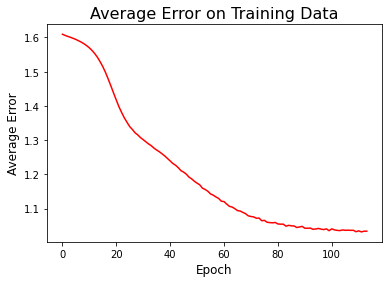

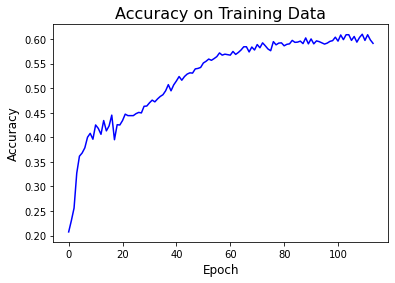

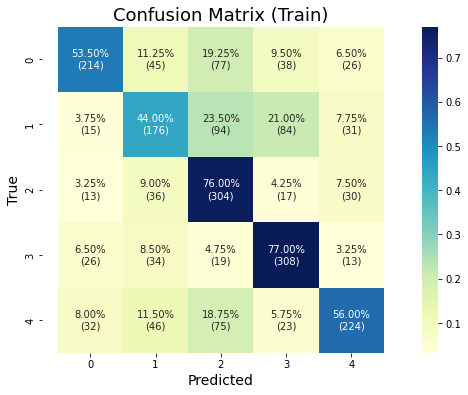

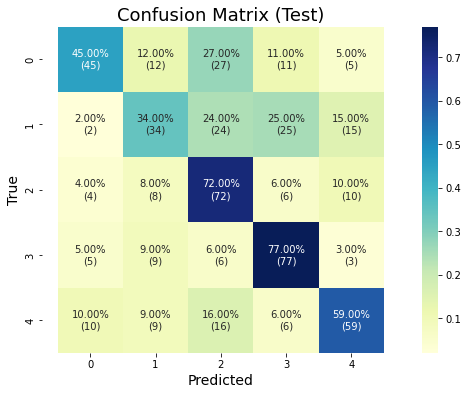

In [20]:
seed_all()
# Delta Rule
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
classifier.optimizer_name = "Delta Rule"
# train_errors, train_accuracies = classifier.train(train_data, train_labels)
# loss, accuracy, predictions = classifier.evaluate(test_data, test_labels)
# print(f"Delta Rule: Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
# classifier.plot_avg_train_error(train_errors)
# classifier.plot_avg_train_accuracy(train_accuracies)
# cm_train = classifier.confusion_matrix_train(train_data, train_labels)
# cm_test = classifier.confusion_matrix_test(test_data, test_labels)
classifier.plot_all(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   5%|▌         | 524/10000 [05:24<1:37:55,  1.61epoch/s]

Converged at epoch 524
Generalized Delta Rule Train: Loss: 0.009172528982162476, Accuracy: 1.0, Epochs: 525
Generalized Delta Rule Validation: Loss: 4.7802958488464355, Accuracy: 0.508
Generalized Delta Rule Test: Loss: 4.026671886444092, Accuracy: 0.556


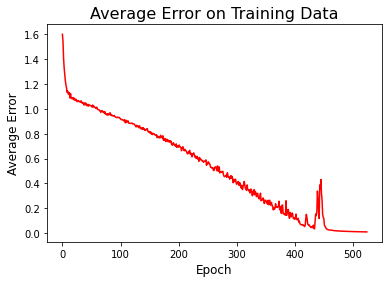

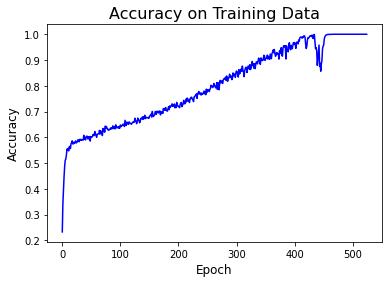

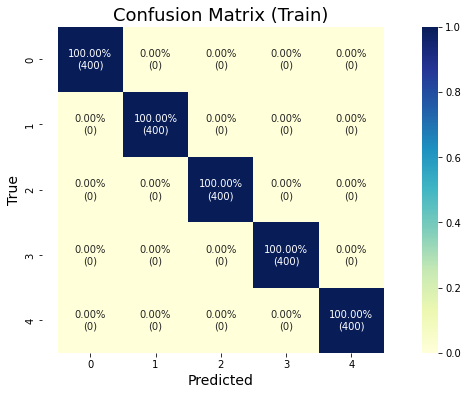

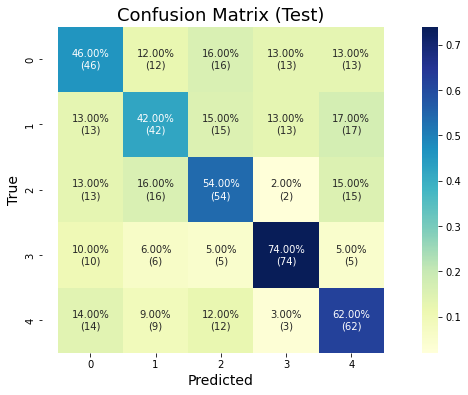

In [21]:
seed_all()
# Generalized Delta Rule
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
classifier = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
classifier.optimizer_name = "Generalized Delta Rule"
classifier.plot_all(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   1%|▏         | 127/10000 [01:04<1:23:47,  1.96epoch/s]

Converged at epoch 127
AdaGrad Train: Loss: 1.015100121498108, Accuracy: 0.614, Epochs: 128
AdaGrad Validation: Loss: 1.1306346654891968, Accuracy: 0.552
AdaGrad Test: Loss: 1.060619592666626, Accuracy: 0.576


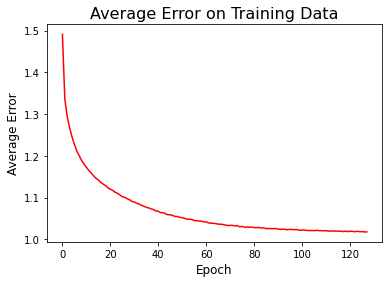

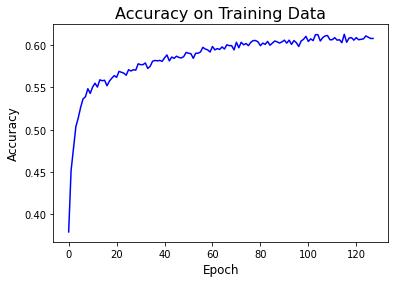

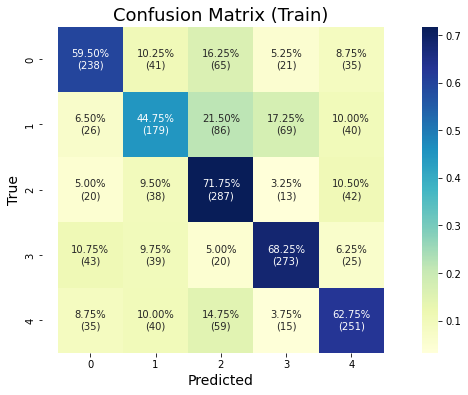

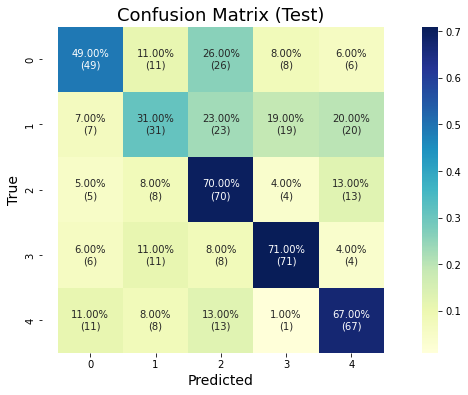

In [22]:
seed_all()
# AdaGrad
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
trainer = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
trainer.optimizer_name = "AdaGrad"
trainer.plot_all(train_data, train_labels, val_data, val_labels, test_data, test_labels)


Training:  19%|█▉        | 1942/10000 [19:02<1:19:00,  1.70epoch/s]

Converged at epoch 1942
RMSProp Train: Loss: 0.025796789675951004, Accuracy: 0.992, Epochs: 1943
RMSProp Validation: Loss: 6.482778549194336, Accuracy: 0.518
RMSProp Test: Loss: 6.1726484298706055, Accuracy: 0.534


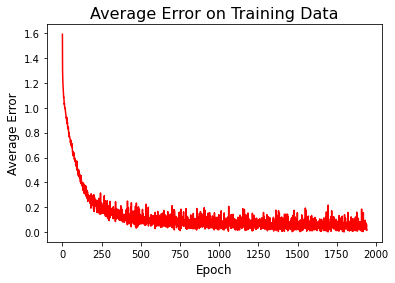

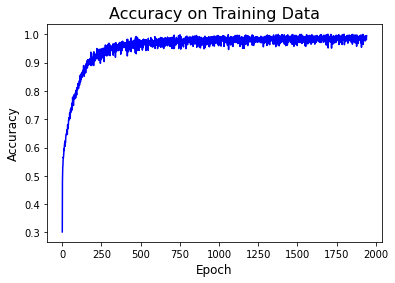

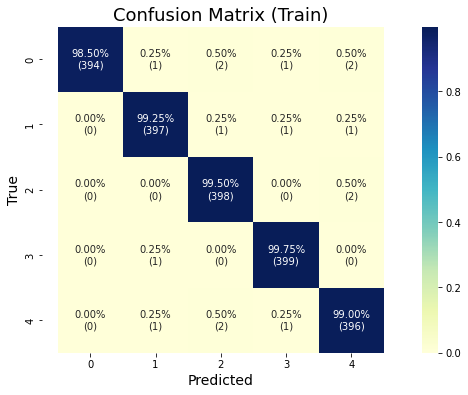

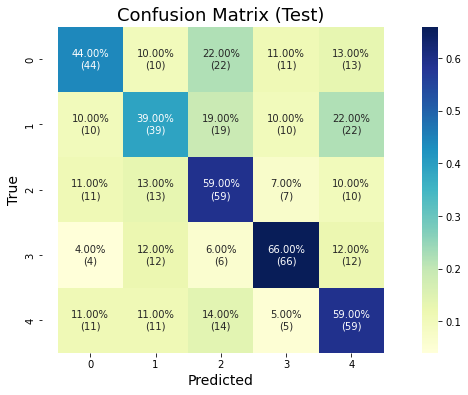

In [23]:
seed_all()
# RMSProp
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
trainer = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
trainer.optimizer_name = "RMSProp"
trainer.plot_all(train_data, train_labels, val_data, val_labels, test_data, test_labels)


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:  18%|█▊        | 1788/10000 [24:18<1:51:36,  1.23epoch/s] 

Converged at epoch 1788
AdaM Train: Loss: 0.004094167146831751, Accuracy: 1.0, Epochs: 1789
AdaM Validation: Loss: 4.864083766937256, Accuracy: 0.52
AdaM Test: Loss: 4.861571788787842, Accuracy: 0.498


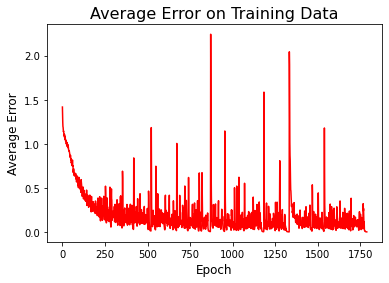

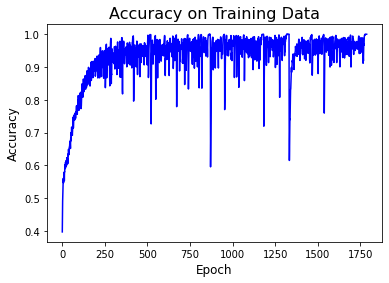

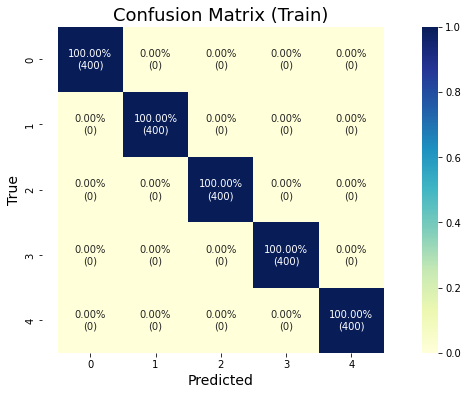

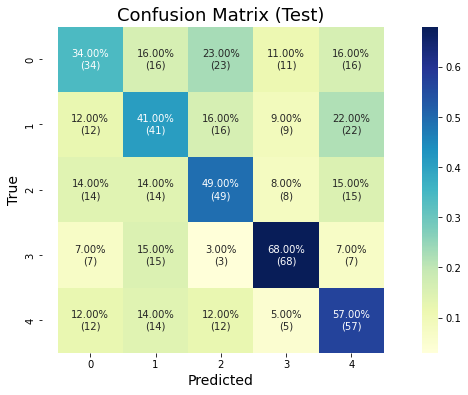

In [24]:
seed_all()
# AdaM
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trainer = NeuralNetworkClassifier(model, criterion, optimizer, epochs, threshold)
trainer.optimizer_name = "AdaM"
trainer.plot_all(train_data, train_labels, val_data, val_labels, test_data, test_labels)
